In [4]:
!pip3 install matplotlib --break-system-packages

  Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
Using cached matplotlib-3.9.2-cp312-cp312-macosx_11_0_arm64.whl (7.8 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.3 MB/s eta 0:00:00
Using cached pillow-10.4.0-cp312-cp312-macosx_11_0_arm64.whl (3.4 MB)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal

from IPython.display import Audio


In [3]:
def wavread(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  # Read in wav file.
  file_handle = open(filename, 'rb')
  samplerate, wave_data = wav.read(file_handle)
  # Normalize short ints to floats in range [-1..1).
  data = np.asarray(wave_data, dtype=np.float32) / 32768.0
  return data, samplerate

def wavwrite(data, samplerate, filename):
  """Write a waveform to a WAV file."""
  wav.write(filename, samplerate, (32768.0 * data).astype(np.int16))

def play(waveform, rate):
    int

filename = 'Piano.ff.D5.wav'
waveform, sr = wavread(filename)
print(sr, waveform.shape)
#Audio(data=waveform.T, rate=sr)

44100 (1344782, 2)


88200
(88200,)


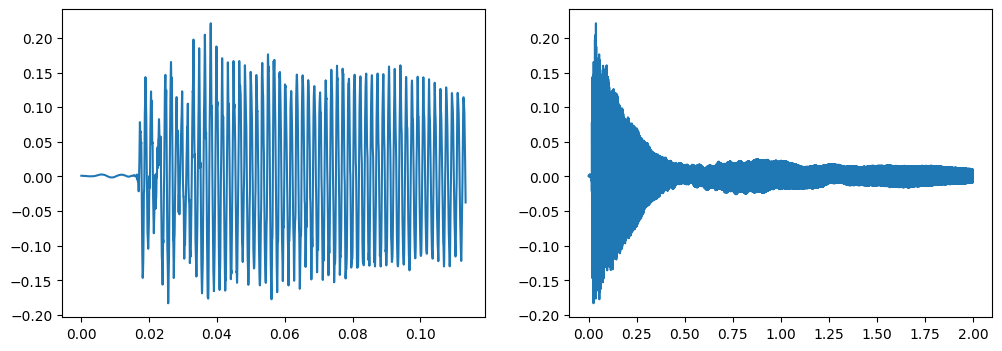

In [4]:
# Extract a segment to analyze, left channel only, dropping some initial silence
drop_initial_time = 0.42
initial_time = 2.0  # sec
print(int(round(initial_time * sr)))
d = waveform[int(round(drop_initial_time * sr)) + np.arange(int(round(initial_time * sr))), 0]
print(d.shape)
t = np.arange(len(d)) / sr
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(t[:5000], d[:5000])
plt.subplot(122)
plt.plot(t, d)

589.0862058163939


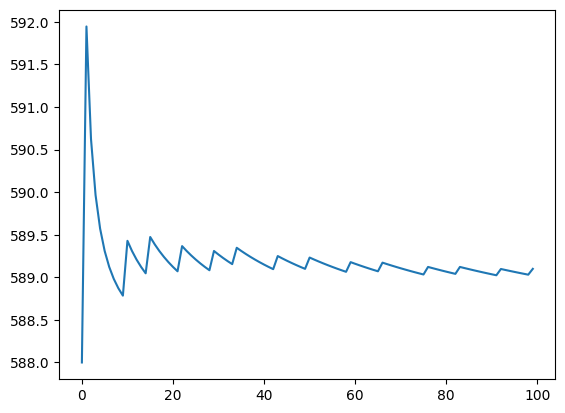

In [5]:
# Estimate fundamental by autocorrelation.
acr = np.correlate(d, d, 'full')[len(d) - 1: len(d) + 10000]
# Find 16th peak, divide by 16
maxima = scipy.signal.argrelextrema(acr, np.greater)[0]
npeaks = 100
freqs = sr * np.arange(1, npeaks + 1) / maxima[:npeaks]
plt.plot(freqs)
freq = np.mean(freqs[-40:])
print(freq)
# Nominal: D5= 587.3295

In [6]:
def lin_to_db(l):
    return 20 * np.log10(l)

def db_to_lin(d):
    return np.pow(10.0, d / 20.0)

In [7]:
def heterodyne_extract(waveform, fundamental_freq, harmonic_number=1.0, sr=44100, smooth_cycles=2.0):
    """Return a full-sample-rate amplitude and frequency envelope near the specified frequency."""
    t = np.arange(len(waveform)) / sr
    h_freq = harmonic_number * fundamental_freq
    complex_exp = np.exp(-1j * 2 * np.pi * h_freq * t)
    f_period = sr / (h_freq / harmonic_number)
    #print("f_period=", f_period)
    smooth_len = int(round(smooth_cycles * f_period * harmonic_number))
    #print("sm_len=", smooth_len)
    smooth_win = np.hanning(smooth_len)
    smooth_win = smooth_win / np.sum(smooth_win)
    smoothed_heterodyne_waveform = np.convolve(smooth_win, waveform * complex_exp, 'same')
    heterodyne_magnitude = np.abs(smoothed_heterodyne_waveform)
    smoothed_dphi_dt = np.diff(np.convolve(smooth_win, np.hstack([[0], np.unwrap(np.angle(smoothed_heterodyne_waveform))]), 'same'))
    inst_freq = h_freq + smoothed_dphi_dt / (2 * np.pi) * sr
    dphi_dt_valid = (np.abs(smoothed_dphi_dt) < 0.5)
    dphi_dt_weighting = heterodyne_magnitude * dphi_dt_valid
    weighted_mean_dphi_dt = np.sum(dphi_dt_weighting * smoothed_dphi_dt) / np.sum(dphi_dt_weighting)   # radians / sample
    avg_freq = h_freq + weighted_mean_dphi_dt / (2 * np.pi) * sr   # cycles / second
    reconstructed_waveform = 2 * np.real(smoothed_heterodyne_waveform * np.conj(complex_exp))
    return lin_to_db(heterodyne_magnitude), inst_freq, avg_freq, reconstructed_waveform

In [8]:
print(np.reshape(np.tile(np.array([[1,2,3,4],[5,6,7,8]])[:,:, np.newaxis], [1, 1, 2]), shape=(2, 8)))

def replicate_last(x, num_reps):
    shape_in = x.shape
    shape_out = np.array(shape_in)
    shape_out[-1] *= num_reps
    return np.reshape(np.tile(x[..., np.newaxis], list(np.ones_like(shape_in)) + [num_reps]), shape=shape_out)

print(replicate_last(np.array([[1,2,3,4],[5,6,7,8]]), 5))

[[1 1 2 2 3 3 4 4]
 [5 5 6 6 7 7 8 8]]
[[1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4]
 [5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8]]


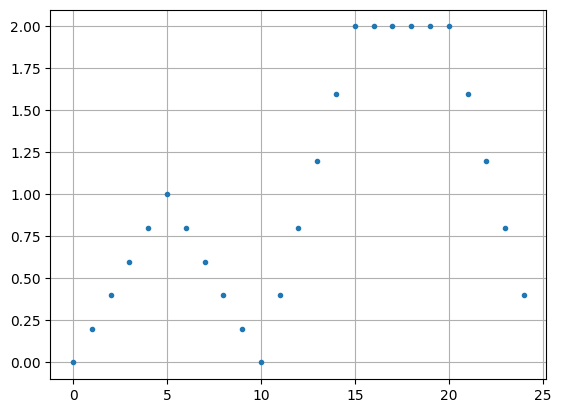

In [9]:
def slinterp(x, interp):
    x_shape = list(x.shape)
    x_out_shape = list(x.shape)
    x_out_shape[-1] *= interp
    x_in_flat = np.reshape(x, (np.prod([1] + x_shape[:-1]), x_shape[-1]))
    n_rows, n_cols = x_in_flat.shape
    x_out_flat = np.zeros((n_rows, interp * n_cols))
    interpolation_window = np.hstack([np.linspace(0, 1, 1 + interp)[1:], np.linspace(1, 0, 1 + interp)[1:]])
    for i in range(x_in_flat.shape[0]):
        x_atrous = np.reshape(np.hstack([x_in_flat[[i], :].T, np.zeros((n_cols, interp - 1))]), (n_cols * interp,))
        x_out_flat[i] = np.convolve(x_atrous, interpolation_window, 'same')
    return np.reshape(x_out_flat, x_out_shape)

plt.plot(slinterp(np.array([[0, 1, 0, 2, 2]]), 5).T, '.')
plt.grid()

(1, 400)


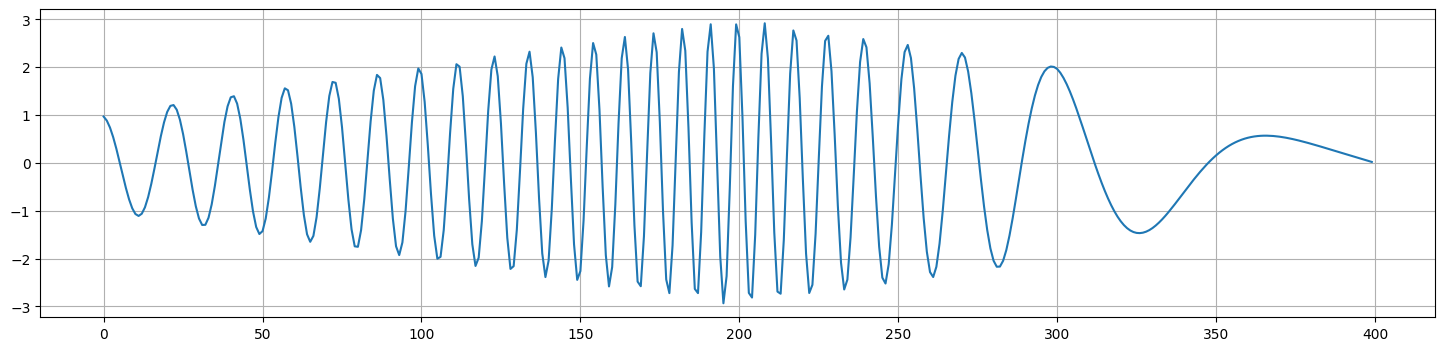

In [10]:
def synth_partial(mag, freq, frame_rate, sr):
    samps_per_frame = int(round(sr / frame_rate))
    num_partials, num_frames = mag.shape
    output_samples = num_frames * samps_per_frame
    t = np.arange(output_samples) / sr
    dt = 1 / sr
    #phase = np.cumsum(np.hstack([np.zeros((num_partials, 1)), slinterp(2 * np.pi * freq * dt, samps_per_frame)]))
    phase = np.cumsum(slinterp(2 * np.pi * freq * dt, samps_per_frame))
    carrier = np.cos(phase)
    return slinterp(mag, samps_per_frame) * carrier

x = synth_partial(np.array([[1, 2, 3, 2]]), np.array([[40, 80, 120, 20]]), 10, 1000)
plt.figure(figsize=(18, 4))
plt.plot(x.T)
plt.grid()
print(x.shape)

(88200,)
(88200,)
pre_freq=589.23 post_freq=588.73 diff=-0.50


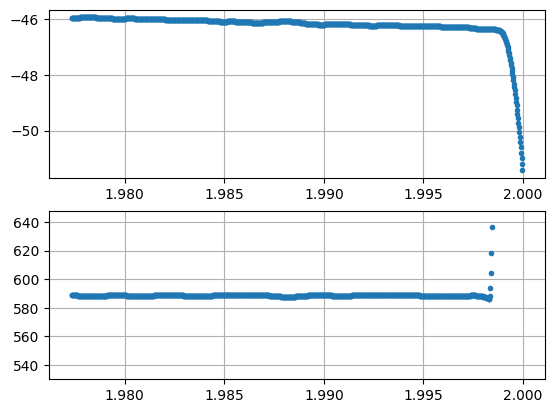

In [11]:
# Heterodyne
# h_num  delta_f
# 1      -0.63
# 2      -6.5
# 3       4.1
# 4      18.7
# 5      35.3
# 6      61.4
# 7     104     4229
# 8.2    31.4   4863
# 9.3    97.1   5518
# 10.2          6003
# 10.8          6222
# 11.2          6593
# 11.7          6890
# 13.3          7830
# 14.15         8343
# 15.45         9097
# 16.7          9845

f_freq = 589.232
harmonic_num = 1
sm_cyc = 2.0

mag, freq, avg_freq, recons_waveform = heterodyne_extract(d, f_freq, harmonic_num, sr, sm_cyc)

t = np.arange(len(d)) / sr
ii = np.arange(2000) # 
ii = np.arange(len(mag)-1000,len(mag))

print(mag.shape)
print(freq.shape)

plt.subplot(211)
#plt.plot(t[ii], db_to_lin(mag[ii]), '.')
plt.plot(t[ii], mag[ii], '.')
plt.grid()
#plt.ylim([-60, -20])

plt.subplot(212)
plt.plot(t[ii], freq[ii], '.')
plt.ylim([0.9 * avg_freq, 1.1 * avg_freq])
plt.grid()

print("pre_freq=%.2f" % (f_freq * harmonic_num), "post_freq=%.2f" % avg_freq, "diff=%.2f" % (avg_freq - f_freq * harmonic_num))

#Audio(data=synth_partial(np.array([db_to_lin(mag)]), np.array([freq]), sr, sr), rate=sr)
#Audio(data=synth_partial(np.array([db_to_lin(mag)]), avg_freq * np.ones((1, len(freq))), sr, sr), rate=sr)

589.232 588.7303322461809 589.232 588.7303322461809
589.232 589.1830451737042 1178.464 1178.3660903474083
589.232 590.8515284544999 1767.696 1772.5545853634997
589.232 593.7301464891221 2356.928 2374.9205859564886
589.232 596.3874154314673 2946.16 2981.9370771573363
589.232 598.9058330142246 3535.392 3593.434998085348
589.232 587.4454233685228 4242.4704 4229.607048253364
589.232 593.1185376126672 4831.702399999999 4863.57200842387
589.232 592.7633602084279 5479.8576 5512.6992499383805
589.232 587.8811435177604 6010.166399999999 5996.387663881155
589.232 588.703713389996 6216.3976 6210.824176264458
589.232 588.9573879351656 6363.7056 6360.739789699789
589.232 588.1841353599827 6599.398399999999 6587.662316031807
589.232 588.8693815808126 6894.014399999999 6889.771764495507
589.232 588.6591139629065 7836.7856 7829.166215706657
589.232 589.6457235807251 8337.6328 8343.48698866726
589.232 588.7523608192373 9103.634399999999 9096.223974657216
589.232 589.4409079144851 9840.1744 9843.6631621

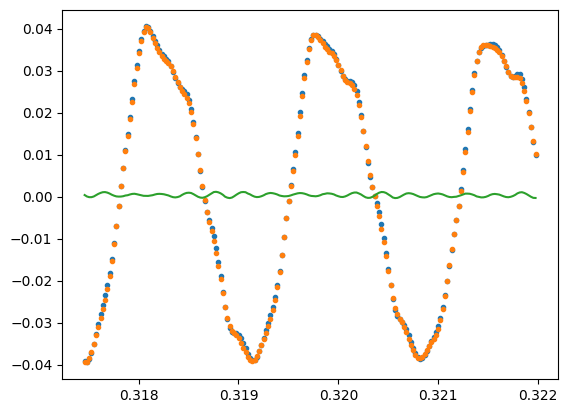

In [12]:
recons_d = np.zeros_like(d)
recons_d_flat_f = np.zeros_like(d)

f_freq = 589.232
sm_cyc = 2.0

d_remaining = np.array(d)

mags = []
freqs = []
avg_freqs = []

h_num_list = [1, 2, 3, 4, 5, 6, 7.2, 8.2, 9.3, 10.2, 10.55, 10.8, 11.2, 11.7, 13.3, 14.15, 15.45, 16.7]

for h_num in h_num_list:
    mag, freq, avg_freq, recons_waveform = heterodyne_extract(d_remaining, f_freq, h_num, sr, sm_cyc)
    # Repeat with estimated frequency
    print(f_freq, avg_freq / h_num, f_freq * h_num, avg_freq)
    if h_num > 8:
        mag, freq, avg_freq, recons_waveform = heterodyne_extract(d, avg_freq / h_num, h_num, sr, sm_cyc)
    recons_d += recons_waveform
    d_remaining -= recons_waveform
    recons_d_flat_f += synth_partial(np.array([db_to_lin(mag)]), avg_freq * np.ones((1, len(freq))), sr, sr)[0]
    mags.append(mag)
    freqs.append(freq)
    avg_freqs.append(avg_freq)

mags = np.array(mags)
freqs = np.array(freqs)
print(mags.shape)

resid = d - recons_d

ii = np.arange(14000, 14200)
plt.plot(t[ii], d[ii], '.', t[ii], recons_d[ii], '.', t[ii], resid[ii])
#Audio(data=d.T, rate=sr)
#Audio(data=recons_d.T, rate=sr)
Audio(data=(resid).T, rate=sr)
#Audio(data=recons_d_flat_f.T, rate=sr)

In [13]:
wavwrite(resid, sr, 'resid.wav')
wavwrite(recons_d, sr, 'recons.wav')

(575.0, 630.0)

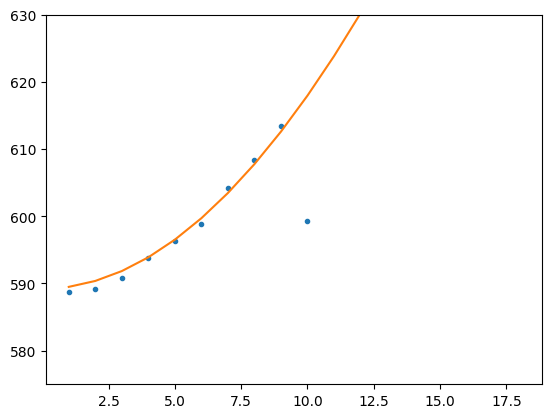

In [14]:
# Fit inharmonicity curve to effective fundamentals
xx = 1 + np.arange(len(avg_freqs))
h_freq = avg_freqs
plt.plot(xx, h_freq / xx, '.', xx, 589.2 * np.sqrt(1 + .001 * xx*xx))
plt.ylim([575, 630])

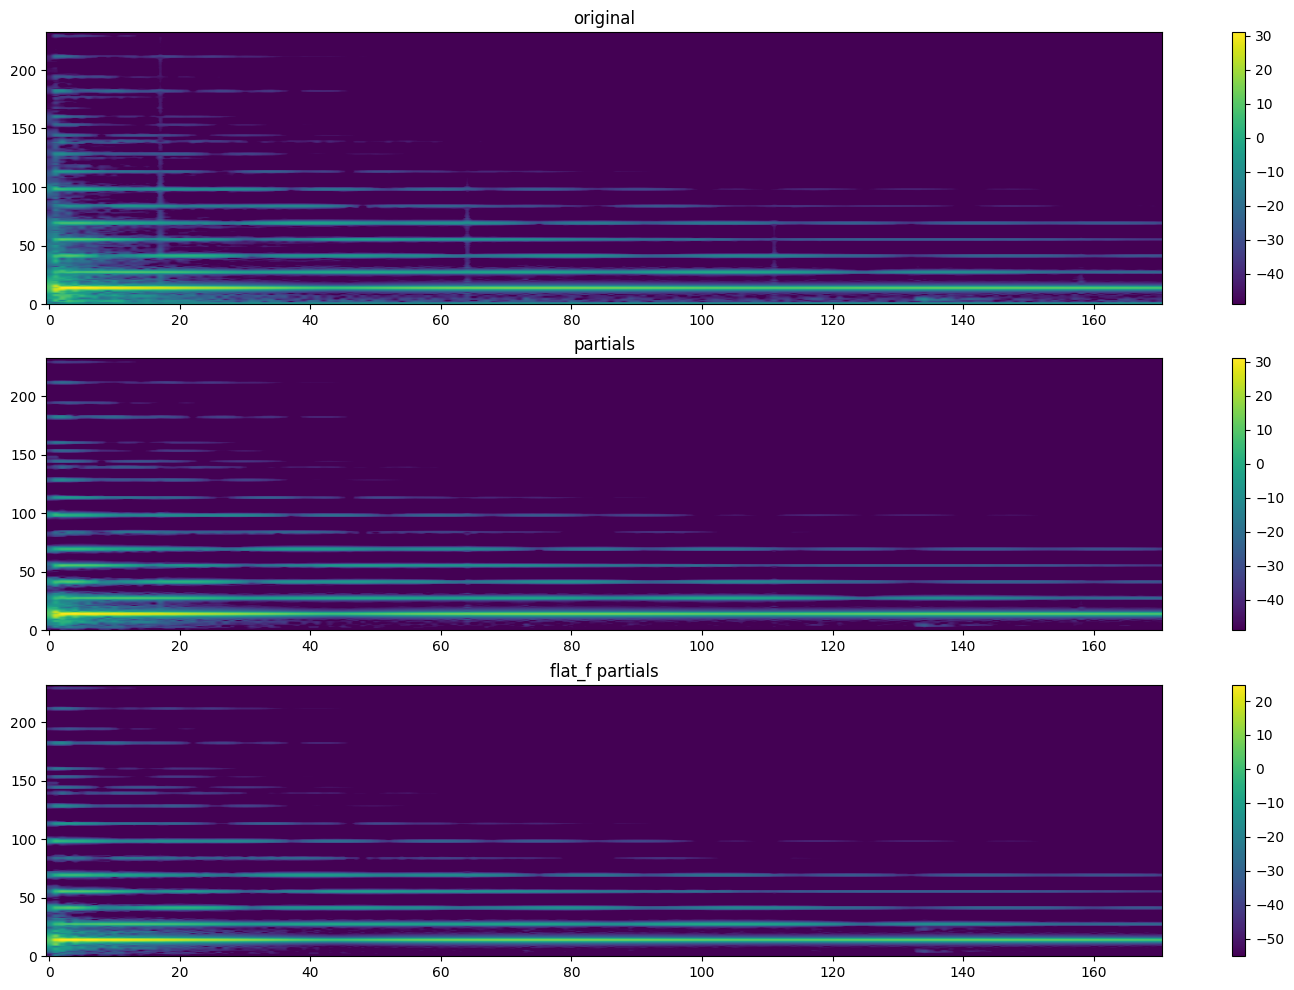

In [15]:
from scipy import fft

def spectrogram(x, fft_len=1024, win_len=None, hop_len=None, window_fn=np.hanning, sr=1, f_max=0.5, title=None):
    if win_len is None:
        win_len = fft_len
    if hop_len is None:
        hop_len = win_len // 2
    # Window.
    prepad_len = (fft_len - win_len) // 2
    win = np.hstack([np.zeros(prepad_len), window_fn(win_len), np.zeros(fft_len - win_len - prepad_len)])
    # Frame.
    frame_indices = np.arange(0, len(x) - win_len, hop_len)[:, np.newaxis] + np.arange(win_len)[np.newaxis, :]
    x_chunks_windowed = x[frame_indices] * win[np.newaxis, :]
    # Transform.
    stft_mag_db = 20 * np.log10(np.abs(fft.fft(x_chunks_windowed, n=fft_len)[:, :(fft_len // 2 + 1)]))
    num_frames, num_bins = stft_mag_db.shape
    t_base = np.arange(num_frames) * hop_len / sr
    f_base = np.arange(num_bins) * sr / 2
    plt.imshow(stft_mag_db.T, aspect='auto', origin='lower')
    plt.clim(np.max(stft_mag_db) + [-80, 0])
    plt.ylim([0, f_max / sr * fft_len])
    #plt.xticks(t_base[plt.xticks()[0].astype(int)[:-1]])
    #plt.yticks(f_base[plt.yticks()[0].astype(int)[:-1]])
    plt.colorbar()
    if title:
        plt.title(title)

plt.figure(figsize=(18, 12))
plt.subplot(311)
spectrogram(d, sr=sr, f_max=10000, title='original')
plt.subplot(312)
spectrogram(recons_d, sr=sr, f_max=10000, title='partials')
plt.subplot(313)
#spectrogram(resid, sr=sr, f_max=10000, title='residual')
spectrogram(recons_d_flat_f, sr=sr, f_max=10000, title='flat_f partials')


[np.float64(-65.56059004159326), 3, np.float64(-48.780516089181006), 22, np.float64(-41.99490305920244), 60, np.float64(-63.15884436068657), 1277, np.float64(-82.10790451762153)]


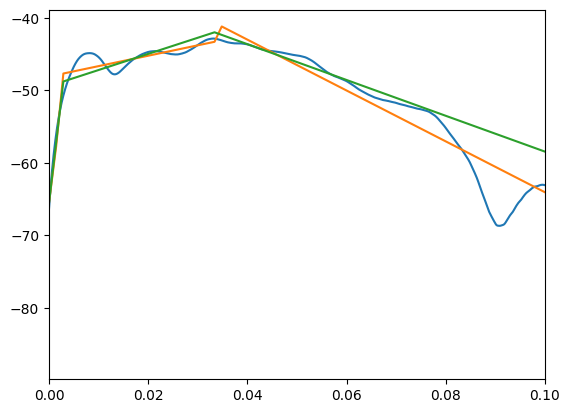

In [16]:
# Piecewise-linear fits to amplitude envelopes.
# from piano-partials.ipynb

def lin_fit(x):
    """Least-squares linear fit to points."""
    # xhat = a + b.index
    # err = x[i] - (a + b.i)
    # err^2 = x[i]^2 - 2 x[i] (a + b.i) + (a^2 + 2 a b i +b^2 i^2)
    # Define axes around midpoint.
    lenx = len(x)
    if not lenx:
        return []
    index = np.arange(lenx) - (lenx - 1) / 2
    # Make x zero mean
    a = np.mean(x)
    x_z = x - a
    b = 0
    if lenx > 1:
        # Linear fit is normalized inner product
        b = np.sum(x_z * index) / np.sum(index * index)
    return a + b * index

def fit_2_segs(x):
    """Fit x with 2 linear segments, searching all divisions."""
    # Try every poss division of remainder.
    besterr = np.sum(np.abs(x))
    besterrpt = 0
    bestxhat = []
    bestseg1 = []
    bestseg2 = []
    for divpt in np.arange(0, len(x)):
        seg1 = lin_fit(x[:divpt + 1])
        seg2 = lin_fit(x[divpt:])
        xhat = np.hstack([seg1[:-1], seg2])
        abserr = np.sum(np.abs(xhat - x))
        if abserr < besterr:
            besterr = abserr
            besterrpt = divpt
            bestseg1 = seg1
            bestseg2 = seg2
            bestxhat = xhat
    # Parameterization is [value, interval, value interval, value...]
    parameters = [bestseg1[0], len(bestseg1), 0.5 * (bestseg1[-1] + bestseg2[0]), len(bestseg2), bestseg2[-1]]
    #print(bestseg1, bestseg2, parameters)
    #print("parameters=", parameters)
    return bestxhat, parameters

def expand_params(params):
    """Convert [val, npts, val, npts, val] sequence to points."""
    val0 = params[0]
    outpts = [[val0]]
    npts_val_pairs = np.vstack([params[1::2], params[2::2]])
    for npts, val in npts_val_pairs.transpose():
        outpts.append(np.linspace(val0, val, int(npts))[1:])
        val0 = val
    return np.concatenate(outpts)

def linseg_fit(x):
    """Approximate sequence x as a set of line segments."""
    # Start with onset slope
    maxpt = np.argmax(x)
    #print("maxpt=", maxpt)
    initial, i_params = fit_2_segs(x[:maxpt + 1])
    tail, t_params = fit_2_segs(x[maxpt:])
    params = i_params[:-1] + [0.5 * (i_params[-1] + t_params[0])] + t_params[1:]
    #print(initial.shape, tail.shape)
    #print(params)
    return np.hstack([initial, tail[1:]]), expand_params(params), params


#i = np.arange(len(mag))
#plt.plot(i[:2000], mag[:2000], i[:2000:64], mag[:2000:64])

hop_len = 64

trim_ends_sec = 0.014
trim_ends_samps = int(round(trim_ends_sec * sr))

hnum = 2
mag_trim = mags[hnum][trim_ends_samps:-trim_ends_samps]

xhat, xhat2, params = linseg_fit(mag_trim[::hop_len])

t = np.arange(len(mag_trim)) / sr
plt.plot(t, mag_trim, t[::hop_len], xhat, t[::hop_len], xhat2)
plt.xlim([0, 0.1])
print(params)

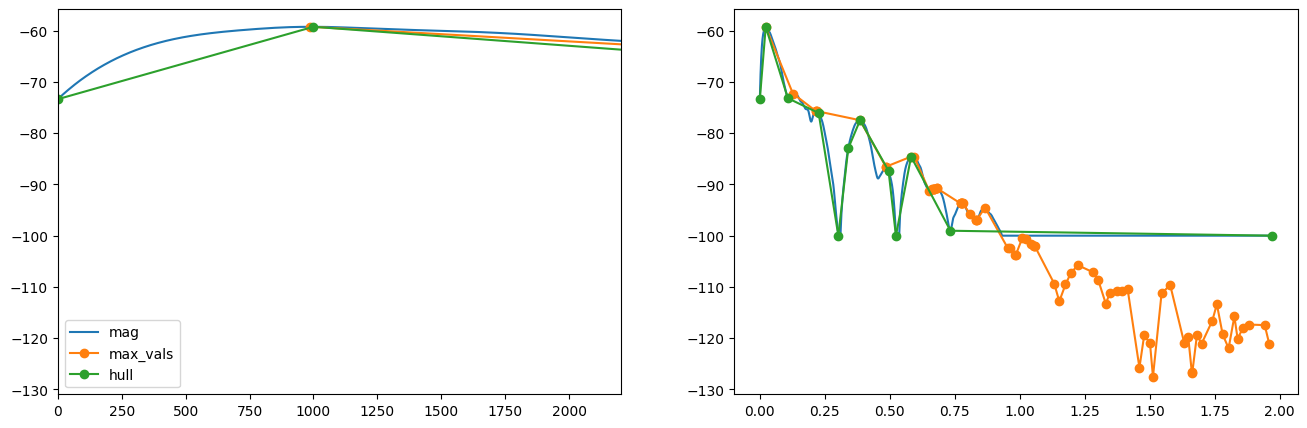

In [17]:
# New approach to linseg fitting - take all extrema, then filter down.
filt_len = 31
#filt_len = 1023
filt_win = np.hanning(filt_len)/np.sum(np.hanning(filt_len))

def lin_hull(x, ends=None):
    if ends is None:
        ends = (x[0], x[-1])
    npts = len(x)
    return np.linspace(ends[0], ends[1], npts)

def max_prominence(x, ends=None, polarity=1):
    prominence = polarity * (x - lin_hull(x, ends))
    argmax_prominence = np.argmax(prominence)
    if np.max(prominence) > 0:
        return argmax_prominence
    return None

def err_from_line(x, ends=None):
    """Return area between x and line seg defined by ends."""
    return np.sum(x - lin_hull(x, ends))

def convex_hull(x, points=None, polarity=1):
    if points is None:
        points = [0, len(x) - 1]
    new_points = [0]
    for start in range(len(points) - 1):
        new_point = max_prominence(x[points[start]:points[start + 1] + 1], polarity)
        if new_point:
            new_points.append(points[start] + int(new_point))
        new_points.append(points[start + 1])
    return new_points

def hull(x, npoints):
    points = [0, len(x) - 1]
    while len(points) < npoints:
        max_err = 0
        for i in range(len(points) - 1):
            start = points[i]
            end = points[i + 1]
            err = err_from_line(x[start : end]) / np.sqrt((end - start))
            if abs(err) > max_err:
                max_err = abs(err)
                worst_seg_ix = i
        worst_start = points[worst_seg_ix]
        worst_end = points[worst_seg_ix + 1]
        polarity = 1 if err_from_line(x[worst_start : worst_end]) > 0 else -1
        points.insert(worst_seg_ix + 1, worst_start + max_prominence(x[worst_start : worst_end], polarity=polarity))
    return np.array(points)

#h = convex_hull(mag_trim)
#print(h)
#h = convex_hull(mag_trim, h, -1)
#print(h)
#h = convex_hull(mag_trim, h)
#print(h)
#h = convex_hull(mag_trim, h, -1)
#print(h)
#h = convex_hull(mag_trim, h)
#print(h)

hnum = 7
mag_filt = lin_to_db(np.convolve(filt_win, db_to_lin(mags[hnum]), 'same'))
mag_filt_trim = mag_filt[trim_ends_samps:-trim_ends_samps]
max_times = scipy.signal.argrelmax(mag_filt_trim)[0]
max_vals = mag_filt_trim[max_times]
t = np.arange(len(mag_filt_trim)) / sr
mmag = np.maximum(-100.0, mag_filt_trim)
h = hull(mmag, 12)
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(t*sr, mmag, t[max_times]*sr, max_vals, 'o-')
plt.plot(h, mmag[h], 'o-')
plt.xlim([0, 0.05 * sr])
plt.legend(['mag', 'max_vals', 'hull'])
plt.subplot(122)
plt.plot(t, mmag, t[max_times], max_vals, 'o-')
plt.plot(h / sr, mmag[h], 'o-')
#plt.xlim([1.9, 2.01])

In [18]:
# Convert sinusoids into bp sets


max_harmonic = 18

dt = 1 / sr

f_freq = 589.232
sm_cyc = 2.0

trim_ends_sec = 0.014
trim_ends_samps = int(round(trim_ends_sec * sr))

harms_params = []

for hnum in range(max_harmonic):
    mag_filt = lin_to_db(np.convolve(filt_win, db_to_lin(mags[hnum]), 'same'))
    mag_filt_trim = mag_filt[trim_ends_samps:-trim_ends_samps]
    mmag = np.maximum(-100.0, mag_filt_trim)
    anchor_times = hull(mmag, 12)
    anchor_vals = mmag[anchor_times]
    nvals = list(zip([0] + list(np.diff(anchor_times)), anchor_vals))
    bp_list = [(int(round(n * dt * 1000)), float(db_to_lin(val))) 
               for n, val in nvals]
    last_time, last_mag = bp_list[-1]
    last_mag_db = lin_to_db(last_mag)
    final_mag_db = -100.0
    if last_mag_db > final_mag_db:
        terminal_slope = 20.0  # -db/sec
        final_dur = (last_mag_db - final_mag_db) / terminal_slope
        bp_list.append((int(round(1000 * final_dur)), float(db_to_lin(final_mag_db))))
    if bp_list[-1][1] == bp_list[-2][1]:  # Final points have same mag
        bp_list = bp_list[:-1]
    bp_list_pair = [float(avg_freqs[hnum]), bp_list]
    print("h", hnum + 1, bp_list_pair)
    harms_params.append(bp_list_pair)
    

h 1 [588.7303322461809, [(0, 0.0003183759280936712), (4, 0.05942463446834628), (4, 0.019017213920200938), (3, 0.07456424206062932), (4, 0.03211996948806711), (9, 0.09079206854603922), (10, 0.06417436882155676), (161, 0.04113575922530802), (305, 0.004179459444875219), (158, 0.00813364918970332), (196, 0.010624284144828064), (1118, 0.004947346497968808), (2694, 1e-05)]]
h 2 [1178.3660903474083, [(0, 0.0002793690336819829), (2, 0.0021976588087683044), (5, 0.005838245531670097), (7, 0.003065981320912732), (2, 0.00024344445740237883), (1, 0.002553211144184102), (7, 0.007484968029050363), (333, 0.0012346672590791037), (858, 0.0018231277860990783), (229, 0.0001726784568776625), (144, 0.0006840286807119472), (386, 0.0001576030029091112), (1198, 1e-05)]]
h 3 [1772.5545853634997, [(0, 0.00048131423642205136), (33, 0.00719299878102724), (75, 0.0001768071748645232), (12, 0.0008472834811783129), (118, 0.0029321302653307407), (121, 0.000189720888525554), (179, 0.0011122816882865238), (525, 0.0001648

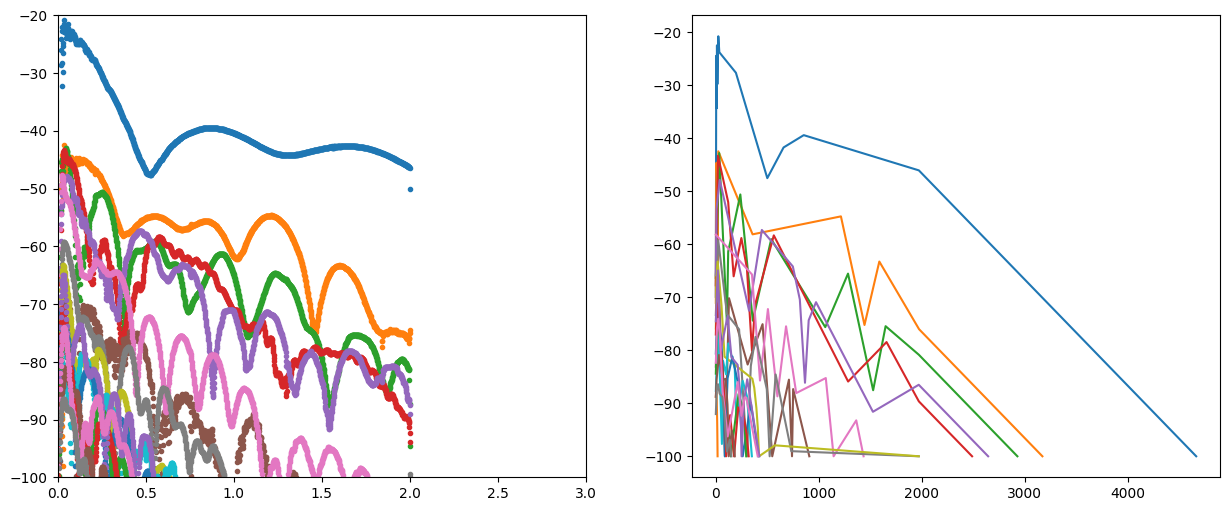

In [19]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
harms = np.arange(len(harms_params))
nfrm = mags[harms, ::hop_len].shape[-1]
frmTime = np.arange(nfrm) * hop_len / sr
_ = plt.plot(frmTime[:nfrm], mags[harms, ::hop_len].T, '.')
plt.ylim([-100, -20])
plt.xlim([0, 3.0])

plt.subplot(1,2,2)
for hp in harms_params:
    times, vals = zip(*np.array(hp[1]))
    times = np.cumsum(times)
    vals = np.array(vals)
    plt.plot(times, lin_to_db(vals))
#plt.xlim([0, 3000])

In [20]:
import json
print(filename.split('.'))
params_file = '.'.join(filename.split('.', -1)[:-1]) + '.json'
print(params_file)
with open(params_file, 'w') as f:
    f.write(json.dumps(harms_params))

['Piano', 'ff', 'D5', 'wav']
Piano.ff.D5.json


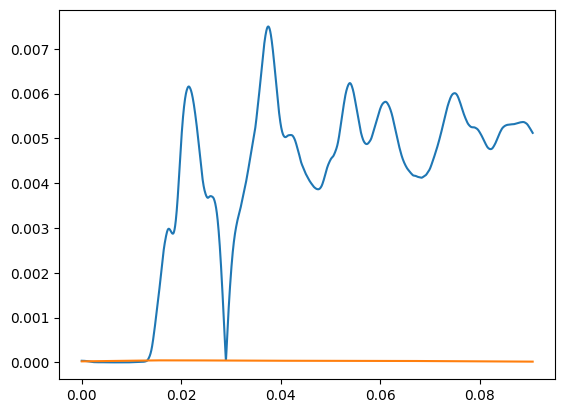

In [21]:
# Synthesize various versions.
# Original magnitudes, fixed frequencies

def synth_params(harms_params):
    result = np.zeros(0)
    for f0, hp in harms_params:
        # ignore first time, start list with first value.
        params = [lin_to_db(hp[0][1])]
        # Step through remaining pairs, converting times in ms to samples
        for bpp in hp[1:]:
            params.extend([int(round(bpp[0] * sr/1000)), lin_to_db(bpp[1])])
        # Expand (val, npoints, val, npoints..., val) list
        ep = expand_params(params)
        carrier = np.cos(2 * np.pi * f0 * np.arange(len(ep)) / sr)
        ep_len = len(ep)
        if ep_len > len(result):
            result = np.hstack([result, np.zeros(ep_len - len(result))])
        result[:ep_len] += db_to_lin(ep) * carrier
    return result, ep

#audio, ep = synth_params([harms_params[i] for i in 1 + np.arange(10)])
h_num = 2
audio, ep = synth_params(harms_params)

f0 = harms_params[0][0]

#ii = np.arange(20000)
ii = np.arange(4000)
plt.plot(t[ii], db_to_lin(mags[h_num - 1][ii]))
plt.plot(t[ii], db_to_lin(ep[ii]))
carrier = np.cos(2 * np.pi * f0 * np.arange(len(ep)) / sr)
#Audio(data=audio, rate=sr)